<div style="background-color:rgba(0, 167, 255, 0.6);border-radius:5px;display:fill">
    <h1><center>Tabular Playground Series - March 2022</center></h1>
</div>

We need to forecast twelve-hours of traffic flow in a major U.S. metropolitan area. Time, space, and directional features are given and our job is to model the congestion of the future timesteps. In this notebook Temporal Fusion Transformers are used to predict the traffice congestion. This is an architecture developed by Oxford University and Google in late 2020 that has beaten Amazon’s DeepAR by 36–69% in benchmark. **Full details can be found <a href="https://arxiv.org/pdf/1912.09363.pdf">here</a>* and  <a href="https://ai.googleblog.com/2021/12/interpretable-deep-learning-for-time.html">here</a>. Quick summary is as below
### **Temporal Fusion Transformers (TFT)** :

* TFT is a novel attentionbased architecture which combines high-performance multi-horizon forecasting with interpretable insights into temporal dynamics. 

* To learn temporal relationships at different scales, TFT uses recurrent layers for local processing and interpretable self-attention layers for long-term dependencies. 

* TFT utilizes specialized components to select relevant features and a series of gating layers to suppress unnecessary components, enabling high performance in a wide range of scenarios 

## <span style="color:crimson;"> DONT FORGET TO UPVOTE IF YOU FIND IT USEFUL.......!!!!!! </span>




# Table of contents
# <a href='#1'>1. Importing Libraries</a><br>
# <a href='#2'>2. Importing Data</a><br>
# <a href='#3'>3. Feature distribution</a><br>
# <a href='#4'>4. Temporal Fusion Transformers</a><br>
# <a href='#5'>5. Tuning and Retrain</a><br>
# <a href='#6'>6. Forecasting </a><br>
# <a href='#7'>7. Postprocessing for Submission </a><br>

<a id="1"></a><h2></h2>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Importing Libraries</center></h1>
</div>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from matplotlib_venn import venn2_unweighted   
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Importing Data</center></h1>
</div>

In [ ]:
df_train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col="row_id", parse_dates=['time'])
df_test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col="row_id", parse_dates=['time'])

<a id="2"></a><h2></h2>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Basic data check</center></h1>
</div>

In [ ]:
print('Train data shape:', df_train.shape)
print('Test data shape:', df_test.shape)

In [ ]:
df_train.head(3)

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Checking for missing values</center></h1>
</div>


In [ ]:
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #000000; color: white;'
}
from IPython.display import HTML

def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

print("=="*30)
print('TRAIN')
print("=="*30)
display(missing_data(df_train).style.set_table_styles([cell_hover, index_names, headers]))
print("=="*30)
print('TEST')
print("=="*30)
display(missing_data(df_test).style.set_table_styles([cell_hover, index_names, headers]))

Based on the above it seems no missing data present in this dataset, which is good indication. However, this is timeseries data, we need reecheck if all the timestep information is provided or not. If any timesereis data missing, our modeling needs to be adjusted accordingly.

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Common samples between train and test</center></h1>
</div>

It better to check is there any common samples between train and test, which will be very valuable information to crosscheck our results and <span style="color:crimson;"> improve our LB score </span>.

In [ ]:
train_df_notarget=df_train.drop(['congestion'], axis = 1)
cols = [e for e in df_test.columns]
common_df = pd.merge(df_train, df_test, how='inner', on=cols)
# depict venn diagram
venn2_unweighted(subsets = (len(df_train) , len(df_test) , len(common_df)), set_labels = ('Train', 'test'))
plt.show()

There is no common data between train and test, hence second layer of crosschecking the predicted result is not possible.

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Deep dive into data </center></h1>
</div>

In [ ]:
print("=="*30)
print('TRAIN')
print("=="*30)
s=df_train.describe()
display(s.style.set_table_styles([cell_hover, index_names, headers]))
print("=="*30)
print('TEST')
print("=="*30)
s=df_test.describe()
display(s.style.set_table_styles([cell_hover, index_names, headers]))

In [ ]:
#
import plotly.express as px
df = px.data.tips()
fig = px.histogram(df_train, x="congestion",color='congestion', template='plotly_white',opacity=0.7)
fig.show()

**Point to note**: It seems there is clearn trend in the conguestion data, however, we need to investigate the reason for outliers. It can be due to special event/ weekend / location specific? 


In [ ]:
#https://www.kaggle.com/pestipeti/eda-ion-switching

fig = make_subplots(rows=3, cols=4,  subplot_titles=["Batch #{}".format(i) for i in range(10)])
i = 0
for row in range(1, 4):
    for col in range(1, 5):
        data = df_train.iloc[(i * 25000):((i+1) * 25000 + 1)]['congestion'].value_counts(sort=False).values
        fig.add_trace(go.Bar(x=list(range(11)), y=data), row=row, col=col)        
        i += 1
fig.update_layout(title_text="Target distribution in different batches", showlegend=False)
fig.show()

There is no clear trend in congestion data, might need to link to time of the day and observe again.

<a id="3"></a><h2></h2>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>FEATURES DISTRIBUTION </center></h1>
</div>

Notes for feature engineering:
Congestion depends on the following
 1) Time of the day ( peak time or off peak time)
 
 2) Day of the week (is it Sunday, Monday, Tuesday....)
 
 3) Is it weekend?
 
 4) direction of the flow.
 
 Keeping the above things in mind, we need to extract all the above features
 


In [ ]:
# Thanks to https://www.kaggle.com/code/martynovandrey/tps-mar-22-fe-model-selection/notebook
def add_datetime_features(df):
    df['month']   = df['time'].dt.month
    df['day']     = df['time'].dt.day
    df['weekday'] = df['time'].dt.weekday
    df['weekend'] = (df['time'].dt.weekday >= 5)
    df['hour']    = df['time'].dt.hour
    df['minute']  = df['time'].dt.minute
    df['afternoon'] = df['hour'] >= 12
    
    # number of 20' period in a day
    df['moment']  = df['time'].dt.hour * 3 + df['time'].dt.minute // 20 
df_train['road'] = df_train['x'].astype(str) + df_train['y'].astype(str) + df_train['direction']
df_test['road']  = df_test['x'].astype(str) + df_test['y'].astype(str) + df_test['direction']

le = LabelEncoder()
df_train['road'] = le.fit_transform(df_train['road'])
df_test['road']  = le.transform(df_test['road'])



add_datetime_features(df_train)
add_datetime_features(df_test)





medians = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.median().astype(int)).reset_index()
medians = medians.rename(columns={'congestion':'median'})
df_train = df_train.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')
mins = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.min().astype(int)).reset_index()
mins = mins.rename(columns={'congestion':'min'})
df_train = df_train.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')
maxs = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.max().astype(int)).reset_index()
maxs = maxs.rename(columns={'congestion':'max'})
df_train = df_train.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_mornings = df_train[(df_train.hour >= 6) & (df_train.hour < 12)]
morning_avgs = pd.DataFrame(df_mornings.groupby(['month', 'day', 'road']).congestion.median().astype(int)).reset_index()
morning_avgs = morning_avgs.rename(columns={'congestion':'morning_avg'})
df_train = df_train.merge(morning_avgs, on=['month', 'day', 'road'], how='left')
df_test = df_test.merge(morning_avgs, on=['month', 'day', 'road'], how='left')
df_train.time = pd.to_datetime(df_train.time)
df_train['time_id'] = ( ( (df_train.time.dt.dayofyear-1)*24*60 + df_train.time.dt.hour*60 + df_train.time.dt.minute ) /20 ).astype(int)
#df_train.drop(columns=['time','moment'],axis=1, inplace=True)

# # thanks to https://www.kaggle.com/code/martynovandrey/tps-mar-22-fe-model-selection
# day = df_train.copy()
# day['time'] = day['time'] + pd.Timedelta(1, unit="d")
# day = day.rename(columns={'congestion':'lag1'})[['time', 'road', 'lag1']]
# df_train = df_train.merge(day, on=['time', 'road'], how='left')
# df_test = df_test.merge(day, on=['time', 'road'], how='left')

# week = df_train.copy()
# week['time'] = week['time'] + pd.Timedelta(7, unit="d")
# week = week.rename(columns={'congestion':'lag7'})[['time', 'road', 'lag7']]
# df_train = df_train.merge(week, on=['time', 'road'], how='left')
# df_test = df_test.merge(week, on=['time', 'road'], how='left')

# df_train['lag1'] = df_train['lag1'].fillna(df_train['median']) #(df_train['median'])
# df_train['lag7'] = df_train['lag7'].fillna(df_train['median']) #(df_train['median'])


df_train.drop(columns=['time'],axis=1, inplace=True)
df_train["weekend"] = df_train["weekend"].astype('category')
df_train["afternoon"] = df_train["afternoon"].astype('category')
df_test["weekend"] = df_test["weekend"].astype('category')
df_test["afternoon"] = df_test["afternoon"].astype('category')
df_train = df_train.drop(['x', 'y', 'direction'], axis=1)
df_test = df_test.drop(['x', 'y', 'direction'], axis=1)

In [ ]:

from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))
def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# df_train['moment_sin'] = sin_transformer(72).fit_transform(df_train["moment"])
df_train['moment_cos'] = cos_transformer(72).fit_transform(df_train["moment"])
# df_test['moment_sin'] = sin_transformer(72).fit_transform(df_test["moment"])
df_test['moment_cos'] = cos_transformer(72).fit_transform(df_test["moment"])
medians = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.median().astype(int)).reset_index()
medians = medians.rename(columns={'congestion':'median'})
df_train = df_train.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')
medians = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.median().astype(int)).reset_index()
medians = medians.rename(columns={'congestion':'median'})
df_train = df_train.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')

In [ ]:
important_features = ['moment', 'median', 'min', 'max', 'morning_avg']
X = df_train.copy()
X_t = df_test.copy()

y = X.pop('congestion')
X = X.loc[:, important_features]
X_t = X_t.loc[:, important_features]

from sklearn.decomposition import PCA

# Create principal components
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X)
X_t_pca = pca.transform(X_t)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_t_pca = pd.DataFrame(X_t_pca, columns=component_names)

df_train = pd.concat([df_train, X_pca], axis=1)
df_test = pd.concat([df_test, X_t_pca], axis=1)

In [ ]:
# extracting time information from testing dataset
df_test.time = pd.to_datetime(df_test.time)
df_test['time_id'] = ( ( (df_test.time.dt.dayofyear-1)*24*60 + df_test.time.dt.hour*60 + df_test.time.dt.minute ) /20 ).astype(int)
prediction_steps = df_test['time_id'].nunique()  

### quick recap on the data we have generated using feature engineering

In [ ]:
df_test.head(3)

In [ ]:
df_train.head(3)

In [ ]:
df_train.describe()

In [ ]:
df_train.isnull().sum().sum(),df_test.isnull().sum().sum()

In [ ]:
# scaling didnt help much in results
# from sklearn.preprocessing import MinMaxScaler
# scaler_hour = MinMaxScaler()
# df_train['hour'] = scaler_hour.fit_transform(df_train['hour'].values.reshape(-1,1))
# df_test['hour'] = scaler_hour.transform(df_test['hour'].values.reshape(-1,1))
# scaler_minute = MinMaxScaler()
# df_train['minute'] = scaler_minute.fit_transform(df_train['minute'].values.reshape(-1,1))
# df_test['minute'] = scaler_minute.transform(df_test['minute'].values.reshape(-1,1))
# scaler_median = MinMaxScaler()
# df_train['median'] = scaler_median.fit_transform(df_train['median'].values.reshape(-1,1))
# df_test['median'] = scaler_median.transform(df_test['median'].values.reshape(-1,1))
# scaler_day = MinMaxScaler()
# df_train['day'] = scaler_day.fit_transform(df_train['day'].values.reshape(-1,1))
# df_test['day'] = scaler_day.transform(df_test['day'].values.reshape(-1,1))

<a id="4"></a><h2></h2>
<div style="background-color:rgba(0, 167, 255, 0.6);border-radius:1px;display:fill">
    <h1><center>Temporal Fusion Transformers </center></h1>
</div>
Here we will use PyTorch Forecasting to do the time series forecasting by providing a high-level API for PyTorch that can directly make use of pandas dataframes. Applied framework is as follows

* Create a training and validation dataset from competition data
* Train the Temporal Fusion Transformer. This is an architecture developed by Oxford University and Google that has beaten Amazon’s DeepAR by 36–69% in benchmarks
* Inspect results on the validation set and interpret the trained model.

In [ ]:
os.chdir("../../..")
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
!pip install pytorch-forecasting   
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Training </center></h1>
</div>

The model is trained such that it uses one week cycle traffic data to predict the next half day. Note that our objective is to predict the half day sales. For that reason max_encoder_length is choosen to be 504 ( reading taken in one week 24 * 7 * 3 ). As other kagglers mentioned some of the time series data is missing hence we have assigned allow_missing_timesteps= True. 

In [ ]:
#importing the library and developing TFT with training data information
import pytorch_forecasting
max_prediction_length = prediction_steps
max_encoder_length = 504
training_cutoff = df_train["time_id"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_train[lambda x: x["time_id"] <= training_cutoff],
    time_idx="time_id",
    target="congestion",
    group_ids=["road"],
    min_encoder_length=0,  
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=["road"],
    time_varying_known_categoricals=["afternoon","weekend"],  
    time_varying_known_reals=["weekend","afternoon","month","day","weekday","time_id","min","max","morning_avg",'PC1','PC2','moment_cos'],
    time_varying_unknown_reals=["congestion"],    
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True    
 )

### Dividing the dataset for training and validation. Other sophesticated CV methods can be used. For now we use simple one.

In [ ]:
validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)
batch_size = 32   # This is one of the parameters that we can tune. I am assuming 32 for now.
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
import pytorch_lightning as pl
from pytorch_forecasting.metrics import QuantileLoss

<a id="5"></a><h2></h2>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Tuning and Retrain </center></h1>
</div>

In [ ]:
#Hyperparameter Optimization
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=50,
    max_epochs=20,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 64),
    hidden_continuous_size_range=(8, 64),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=100, limit_test_batches=100, limit_val_batches=100, log_every_n_steps=15, gpus=1),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
    timeout=7200  # we can increase the timTRUEeout for better tuning.
)
# show best hyperparameters
print(study.best_trial.params)

In [ ]:
# Retrain the full model
#Early Stopping 
MIN_DELTA  = 1e-4
PATIENCE = 10

#PL Trainer
MAX_EPOCHS = 300   # this also one of the tuning parameters to imporve the score.
GPUS = 1
GRADIENT_CLIP_VAL=study.best_trial.params['gradient_clip_val']
LIMIT_TRAIN_BATCHES=100

#Fusion Transformer
LR = study.best_trial.params['learning_rate']
HIDDEN_SIZE = study.best_trial.params['hidden_size']
DROPOUT = study.best_trial.params['dropout']
ATTENTION_HEAD_SIZE = study.best_trial.params['attention_head_size']
HIDDEN_CONTINUOUS_SIZE = study.best_trial.params['hidden_continuous_size']
OUTPUT_SIZE=7
REDUCE_ON_PLATEAU_PATIENCE=5

In [ ]:
#applying tuned parametrs
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=MIN_DELTA, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    gpus=GPUS,
    weights_summary="top",
    gradient_clip_val=GRADIENT_CLIP_VAL,
    limit_train_batches=LIMIT_TRAIN_BATCHES,#comment in for training, running validation every 30 batches
    limit_test_batches=100,
    limit_val_batches=100,
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    log_every_n_steps=10
    
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LR,
    hidden_size=HIDDEN_SIZE,
    attention_head_size=ATTENTION_HEAD_SIZE,
    dropout=DROPOUT,
    hidden_continuous_size=HIDDEN_CONTINUOUS_SIZE,
    output_size=OUTPUT_SIZE,# 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=REDUCE_ON_PLATEAU_PATIENCE,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [ ]:
%%time
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>QC of the results </center></h1>
</div>

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

### Visual verification 

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(5):  # plot 5 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

<a id="6"></a><h2></h2>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Forecasting</center></h1>
</div>

Once we have sucessfully trained the model, we will use last one week data to predict next half day. 
Encoder consister of last one week information from training dataset and deconder consists of test data set information.

In [ ]:
encoder_data = df_train[lambda x: x.time_id > x.time_id.max() - max_encoder_length]
decoder_data=df_test.copy()
decoder_data['congestion']=10 #dummy
#decoder_data=decoder_data.drop(columns=['time','moment'],axis=1)
decoder_data=decoder_data.drop(columns=['time'],axis=1)
decoder_data.describe()

In [ ]:
encoder_data.head(2)

In [ ]:
decoder_data.head(2)

In [ ]:
encoder_data.isnull().sum().sum(),decoder_data.isnull().sum().sum()

In [ ]:
# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
new_prediction_data.describe()

In [ ]:
new_prediction_data

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(2):  # plot 2 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

<a id="7"></a><h2></h2>
<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Postprocessing for Submission</center></h1>
</div>

In [ ]:
predictions = best_tft.predict(new_prediction_data, mode="prediction", return_x=False)
predictions.shape

The shape of the prediction is 65x36. Here 65 represents the 65 different directions which we have identified during EDA and 36 refers to total number of readers in half day

In [ ]:
predictions_df = pd.DataFrame(predictions.numpy()).T
predictions_df.head(5)

In [ ]:
predictions_df['time_id'] = sorted(df_test['time_id'].unique())
predictions_df.tail(2)

In [ ]:
predictions_df2 = pd.melt(predictions_df, id_vars=['time_id'])
predictions_df2.rename(columns = {'value':'congestion', 'variable':'road'}, inplace = True)
predictions_df2.head(2)

In [ ]:
#now copying the results back to df_test as per location and time
result = pd.merge(df_test, predictions_df2, on=["time_id", "road"])
result

In [ ]:
submission = pd.read_csv('kaggle/input/tabular-playground-series-mar-2022/sample_submission.csv')
submission.head(2)

In [ ]:
submission['congestion'] = result['congestion']
submission['congestion'] = submission['congestion'].round().astype(int)
assert (submission['congestion'] >= 0).all()
assert (submission['congestion'] <= 100).all()
#submission.to_csv('kaggle/working/submission.csv', index=False)

In [ ]:
submission.head(2)

### As of now LB score is 5.2, will be improved further.

### Step-1: treating special values

In [ ]:
special = pd.read_csv('kaggle/input/tps-mar-22-special-values/special v2.csv', index_col="row_id")
special = special[['congestion']].rename(columns={'congestion':'special'})


In [ ]:
sub_special = submission.merge(special, left_index=True, right_index=True, how='left')
sub_special.head()

In [ ]:
sub_special['special'] = sub_special['special'].fillna(sub_special['congestion']).round().astype(int)
sub_special.head()

In [ ]:
sub_special = sub_special.drop(['congestion'], axis=1).rename(columns={'special':'congestion'})
sub_special.head(2)

In [ ]:
# Read and prepare the training data
from sklearn.metrics import mean_absolute_error
train = pd.read_csv('kaggle/input/tabular-playground-series-mar-2022/train.csv', parse_dates=['time'])
train['hour'] = train['time'].dt.hour
train['minute'] = train['time'].dt.minute

submission_in = sub_special.copy()
# Compute the quantiles of workday afternoons in September except Labor Day
sep = train[(train.time.dt.hour >= 12) & (train.time.dt.weekday < 5) &
            (train.time.dt.dayofyear >= 246)]
lower = sep.groupby(['hour', 'minute', 'x', 'y', 'direction']).congestion.quantile(0.15).values
upper = sep.groupby(['hour', 'minute', 'x', 'y', 'direction']).congestion.quantile(0.7).values

# Clip the submission data to the quantiles
submission_out = submission_in.copy()
submission_out['congestion'] = submission_in.congestion.clip(lower, upper)

# Display some statistics
mae = mean_absolute_error(submission_in.congestion, submission_out.congestion)
print(f'Mean absolute modification: {mae:.4f}')
print(f"Submission was below lower bound: {(submission_in.congestion <= lower - 0.5).sum()}")
print(f"Submission was above upper bound: {(submission_in.congestion > upper + 0.5).sum()}")

# Round the submission
submission_out['congestion'] = submission_out.congestion.round().astype(int)
submission_out.to_csv('kaggle/working/submission.csv',index=False)
submission_out

### As of now LB score is 4.823, will be improved further.

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Wayforword </center></h1>
</div>

1) Tune the hyper parameters.

2) More feature engineering and apply special treatment to noise (special values)



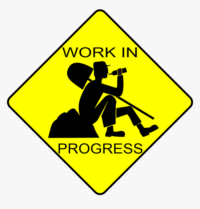

## THANKS. YOU HAVE MADE IT HERE....DONT FORGET TO UPVOTE IF YOU FIND IT USEFUL.......!!!!!!

**References:**

I am here to learn, pleaase let me know if I have missed anyone in my list. Happy to include. Please upvote original works developed by other kagglers listed below also.

https://www.kaggle.com/ambrosm/tpsmar22-eda-which-makes-sense


https://www.kaggle.com/chaudharypriyanshu/febtabular-eda-fast-baseline

https://arxiv.org/pdf/1912.09363.pdf

https://www.kaggle.com/sytuannguyen/tps-mar-2022-eda-model

https://www.kaggle.com/martynovandrey/tps-mar-22-multioutput-cat-modeless

https://www.kaggle.com/luisblanche/pytorch-forecasting-temporalfusiontransformer

https://www.kaggle.com/shreyasajal/pytorch-forecasting-for-time-series-forecasting



